# Kaggle Dog Bred Classifier

Have built model but to better predict Henry, need to train on full model, not 80% of only a half data set (i.e. 40% of the full Stanford model).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [ ]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.gpu_options.visible_device_list = "0"

#set_session(tf.Session(config=config))

num_cores = 4


config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 1})  #GPUs set to zero so we only use CPU
session = tf.Session(config=config)
set_session(session)



In [3]:
#from keras.backend.tensorflow_backend import clear_session
#clear_session()

In [4]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler


In [5]:
from io import BytesIO
import cv2
from tqdm import tqdm

import re

import time
from datetime import timedelta

import PIL.Image

from scipy.stats import itemfreq
import scipy.io as sio

from sklearn.model_selection import train_test_split


## Import data - taken from a Kaggle kernel example

### Set up the import

In [6]:
stanford_list_path = "./lists/file_list.mat"
file_list = sio.loadmat(stanford_list_path)

In [7]:
file_list

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:29:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'file_list': array([[array(['n02085620-Chihuahua/n02085620_10074.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10131.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10621.jpg'], dtype='<U39')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9844.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9924.jpg'], dtype='<U48')]],
       dtype=object),
 'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_10074'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10131'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10621'], dtype='<U35')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829'], dtype='<U44')],


In [8]:
f = file_list['file_list']
#print(f)
f = np.squeeze(f)
#print(f)
#files = np.squeeze(files)
dog_pattern = re.compile(r'(?<=-)[^\/]+')
file_names = list()
dog_names = list()
for name in f:
    #print(name)
    file_names.append(name[0])
    match = dog_pattern.search(name[0])
    dog_names.append(match.group(0))
    #print(match)
    #dog_names.append(dog_pattern.search(name[0]).group(1))
#file_names = np.array(file_names)
print(file_names[300],dog_names[300])


n02085782-Japanese_spaniel/n02085782_4574.jpg Japanese_spaniel


In [9]:
l = file_list['labels']
labels = list()
for name in l:
    labels.append(name[0])

dog_name_list = dict(list(zip(labels,dog_names)))
print(dog_name_list)


{1: 'Chihuahua', 2: 'Japanese_spaniel', 3: 'Maltese_dog', 4: 'Pekinese', 5: 'Shih-Tzu', 6: 'Blenheim_spaniel', 7: 'papillon', 8: 'toy_terrier', 9: 'Rhodesian_ridgeback', 10: 'Afghan_hound', 11: 'basset', 12: 'beagle', 13: 'bloodhound', 14: 'bluetick', 15: 'black-and-tan_coonhound', 16: 'Walker_hound', 17: 'English_foxhound', 18: 'redbone', 19: 'borzoi', 20: 'Irish_wolfhound', 21: 'Italian_greyhound', 22: 'whippet', 23: 'Ibizan_hound', 24: 'Norwegian_elkhound', 25: 'otterhound', 26: 'Saluki', 27: 'Scottish_deerhound', 28: 'Weimaraner', 29: 'Staffordshire_bullterrier', 30: 'American_Staffordshire_terrier', 31: 'Bedlington_terrier', 32: 'Border_terrier', 33: 'Kerry_blue_terrier', 34: 'Irish_terrier', 35: 'Norfolk_terrier', 36: 'Norwich_terrier', 37: 'Yorkshire_terrier', 38: 'wire-haired_fox_terrier', 39: 'Lakeland_terrier', 40: 'Sealyham_terrier', 41: 'Airedale', 42: 'cairn', 43: 'Australian_terrier', 44: 'Dandie_Dinmont', 45: 'Boston_bull', 46: 'miniature_schnauzer', 47: 'giant_schnauzer

In [10]:

#labels = pd.DataFrame(list(zip(file_names,dog_names,labels)), columns = ['file','breed', 'label'])
labels_raw = pd.DataFrame(list(zip(file_names,dog_names)), columns = ['file','breed'])
labels_raw.sample(5)
#labels[200]
#file = './' + labels[200][0]
#print(file)

,file,breed
16669,n02110063-malamute/n02110063_1104.jpg,malamute
20129,n02115641-dingo/n02115641_12922.jpg,dingo
10284,n02099712-Labrador_retriever/n02099712_6446.jpg,Labrador_retriever
19230,n02113023-Pembroke/n02113023_3563.jpg,Pembroke
13076,n02105251-briard/n02105251_8345.jpg,briard


## Create one-hot lables and load data

In [11]:
#df_labels = pd.read_csv('./labels.csv')
#df_submission = pd.read_csv('./sample_submission.csv')   ## <<<< This was the only line used in the original

#targets_series = pd.Series(df_labels['breed'])
#one_hot = pd.get_dummies(targets_series, sparse = True)

#one_hot_labels = np.asarray(one_hot)

In [12]:
#labels_raw = pd.read_csv("./labels.csv", header=0, sep=',', quotechar='"')

#labels_raw.sample(5)


In [13]:
targets_series = pd.Series(labels_raw['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [14]:
one_hot

,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,Blenheim_spaniel,Border_collie,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Define target image size

In [15]:
image_resize = 128
X = []
y = []
X_TESTING = []
Train = []
Train_labels = []

#### Load X

In [16]:
i = 0 
for f, breed in tqdm(labels_raw.values):
    img = cv2.imread('./Images/{}'.format(f))
 #   label = one_hot_labels[i]
    Train.append(cv2.resize(img, (image_resize, image_resize)))
 #   Train_labels.append(label)
    i += 1

100%|██████████| 20580/20580 [02:21<00:00, 144.93it/s]


In [17]:
type(Train)

list

In [18]:
#Train_df = pd.DataFrame(list(zip(Train_labels, Train)))
#Train_df

In [19]:
#y_raw = np.array(Train_labels, np.uint8)
X_raw = np.array(Train, np.float32) / 255.


In [20]:
print(X_raw.shape)
#print(y_raw.shape)


(20580, 128, 128, 3)


In [21]:
#num_class = y_train_raw.shape[1]
#num_class

## Limit the number of Dog Breeds in the data in order to simplify the initial calcs

In [22]:
Nber_of_breeds = 120

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
#    print ('Item frequency:')
#    print (labels_freq_pd)
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = X_raw[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 120 main breeds : (20580,)
- The shape of train_filtered dataset is : (20580, 128, 128, 3)


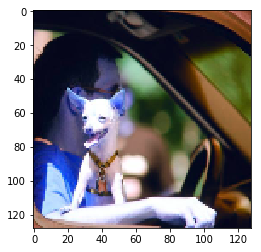

In [23]:
#let's check one image from the train data base
lum_img = train_filtered[100,:,:,:]
plt.imshow(lum_img)
plt.show()

In [24]:
X_raw = []

#### Load the lables

### Create 'One-Hot' labels for the data

In [25]:
#We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(20580, 1)

In [26]:
#Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [27]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 120
Shape : (20580, 120)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))
labels[0:9]

Breed 0 : Afghan_hound
Breed 1 : African_hunting_dog
Breed 2 : Airedale
Breed 3 : American_Staffordshire_terrier
Breed 4 : Appenzeller
Breed 5 : Australian_terrier
Breed 6 : Bedlington_terrier
Breed 7 : Bernese_mountain_dog
Breed 8 : Blenheim_spaniel
Breed 9 : Border_collie
Breed 10 : Border_terrier
Breed 11 : Boston_bull
Breed 12 : Bouvier_des_Flandres
Breed 13 : Brabancon_griffon
Breed 14 : Brittany_spaniel
Breed 15 : Cardigan
Breed 16 : Chesapeake_Bay_retriever
Breed 17 : Chihuahua
Breed 18 : Dandie_Dinmont
Breed 19 : Doberman
Breed 20 : English_foxhound
Breed 21 : English_setter
Breed 22 : English_springer
Breed 23 : EntleBucher
Breed 24 : Eskimo_dog
Breed 25 : French_bulldog
Breed 26 : German_shepherd
Breed 27 : German_short-haired_pointer
Breed 28 : Gordon_setter
Breed 29 : Great_Dane
Breed 30 : Great_Pyrenees
Breed 31 : Greater_Swiss_Mountain_dog
Breed 32 : Ibizan_hound
Breed 33 : Irish_setter
Breed 34 : Irish_terrier
Breed 35 : Irish_water_spaniel
Breed 36 : Irish_wolfhound
Bre

array([['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua']], dtype=object)

# Create Test/Train data


In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_filtered, labels_bin, test_size=0.05, random_state=50)
X_train.shape

(19551, 128, 128, 3)

In [30]:
y_train.shape

(19551, 120)

In [31]:
y_test.shape

(1029, 120)

In [32]:
train_filtered = []

In [33]:
Train = []

In [34]:
X_raw = []

# Create the Keras model

In [35]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu',
                 input_shape = (image_resize, image_resize, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.25))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(Nber_of_breeds, activation='softmax'))

### Augmentation - taken from an MNIST CNN kernel 

In [36]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            horizontal_flip = True,
                            vertical_flip = True,
                            rotation_range = 90)

In [37]:
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.8 ** x)

#### Compile it

In [38]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

### Run it!

In [39]:
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                           #steps_per_epoch=500,
                           epochs=3, #Increase this when not on Kaggle kernel  WAS SET TO 20 originally
                           verbose=2,  #1 for ETA, 0 for silent
                           #validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           validation_data=(X_test[:250,:], y_test[:250,:]), 
                           #initial_epoch = 1,                           
                           callbacks=[annealer]
                          )

Epoch 1/3
 - 186s - loss: 5.8748 - acc: 0.0216 - val_loss: 5.0006 - val_acc: 0.0280
Epoch 2/3
 - 193s - loss: 5.0924 - acc: 0.0320 - val_loss: 4.6414 - val_acc: 0.0520
Epoch 3/3
 - 199s - loss: 4.9071 - acc: 0.0382 - val_loss: 4.6221 - val_acc: 0.0480


## Evaluate

We only used a subset of the validation set during training, to save time. Now let's check performance on the whole validation set.


In [ ]:

final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))


In [ ]:

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [ ]:
model.summary()

In [ ]:
model.summary()

#### Load X_TESTING

In [ ]:
#for f in tqdm(df_submission['id'].values):
#    img = cv2.imread('../input/test/{}.jpg'.format(f))
#    X_TESTING.append(cv2.resize(img, (im_size, im_size)))
#X_TESTING  = np.array(x_test, np.float32) / 255.

In [ ]:
#for f in tqdm(df_submission['id'].values):
X_TESTING = []
img = cv2.imread('./Henry_cropped.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry2.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry3.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry4.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry5.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry7.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Amanda.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Corinne.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Jing.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Karen.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Labrador.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Pam.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
X_TESTING  = np.array(X_TESTING, np.float32) / 255.

In [ ]:
prediction = model.predict(X_TESTING, verbose=1)

In [ ]:
prediction[0][0]

In [ ]:
sub = pd.DataFrame(prediction)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
#sub.insert(0, 'id', labels_raw['id'])
actual_names = ['Henry1','Henry2','Henry3','Henry4','Henry5','Henry7', 'Amanda','Corinne','Jing','Karen','Labrador','Pam']
sub.insert(0, 'id', actual_names)

sub

In [ ]:
dog_names = one_hot.columns.values
#np.save('dog_labels',dog_names)

In [ ]:
h5f = h5py.File('dog_labels.h5', 'w')
dog_names = 
h5f.create_dataset('dogs', data=one_hot.columns.values.astype('U'))   # save the col_names list created above from the one-hot labels
h5f.close()

In [ ]:
h5f.close()

In [ ]:
sub = sub.set_index('id')
sub


In [ ]:
dog_names

# Save the model to file

In [ ]:
import h5py
model.save('dog_classifier.h5') # save the model

In [ ]:
del model

# Load the model from file

In [ ]:
from keras.models import load_model
model = load_model('dog_classifier.h5')

In [ ]:
nlargest = 10
order = np.argsort(-sub.values, axis=1)[:, :nlargest]
result = pd.DataFrame(sub.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=sub.index)

print(result)

In [ ]:



prediction = model.predict(np.array(tk.texts_to_sequences(text)))
print(prediction)